In [1]:
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

In [2]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [3]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(1, 16,  kernel_size=3) , 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=3), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.fc = nn.Linear(32*4*4, 1)
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)
        x = x.view(-1, 32*4*4)
        x = self.fc(x)
        return x

In [4]:
%%time
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      ])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='train', transform=data_transform, download=download)

accs_val = []

for seed in  range(0, 50):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(train_dataset, indx_train)
  val_data = Subset(val_dataset, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=32, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=128, 
                                             shuffle=False)

  model = Net()
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

  for epoch in range(50):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
  accs_val.append(test(model, device, val_loader))

accs_val = np.array(accs_val)

print('Val acc over 5 instances on dataset: %s %.2f +- %.2f (var: %.2f)'%(data_flag, accs_val.mean(), accs_val.std(), accs_val.var()))
     

Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.693146
Train Epoch: 5 [0/10 (0%)]	Loss: 0.685158
Train Epoch: 10 [0/10 (0%)]	Loss: 0.666008
Train Epoch: 15 [0/10 (0%)]	Loss: 0.620920
Train Epoch: 20 [0/10 (0%)]	Loss: 0.526671
Train Epoch: 25 [0/10 (0%)]	Loss: 0.368054
Train Epoch: 30 [0/10 (0%)]	Loss: 0.199040
Train Epoch: 35 [0/10 (0%)]	Loss: 0.081805
Train Epoch: 40 [0/10 (0%)]	Loss: 0.022070
Train Epoch: 45 [0/10 (0%)]	Loss: 0.004534


c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 1.0686, Accuracy: 818/1000 (81.80%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.692915
Train Epoch: 5 [0/10 (0%)]	Loss: 0.683640
Train Epoch: 10 [0/10 (0%)]	Loss: 0.663888
Train Epoch: 15 [0/10 (0%)]	Loss: 0.622211
Train Epoch: 20 [0/10 (0%)]	Loss: 0.538408
Train Epoch: 25 [0/10 (0%)]	Loss: 0.395547
Train Epoch: 30 [0/10 (0%)]	Loss: 0.238146
Train Epoch: 35 [0/10 (0%)]	Loss: 0.099529
Train Epoch: 40 [0/10 (0%)]	Loss: 0.022267
Train Epoch: 45 [0/10 (0%)]	Loss: 0.004872

Val set: Average loss: 1.2582, Accuracy: 753/1000 (75.30%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.693295
Train Epoch: 5 [0/10 (0%)]	Loss: 0.675083
Train Epoch: 10 [0/10 (0%)]	Loss: 0.620139
Train Epoch: 15 [0/10 (0%)]	Loss: 0.475252
Train Epoch: 20 [0/10 (0%)]	Loss: 0.229035
Train Epoch: 25 [0/10 (0%)]	Loss: 0.060260
Train Epoch: 30 [0/10 (0%)]	Loss: 0.012434
Train Epoch: 35 [0/10 (0%)]	Loss: 0.002046
Tr

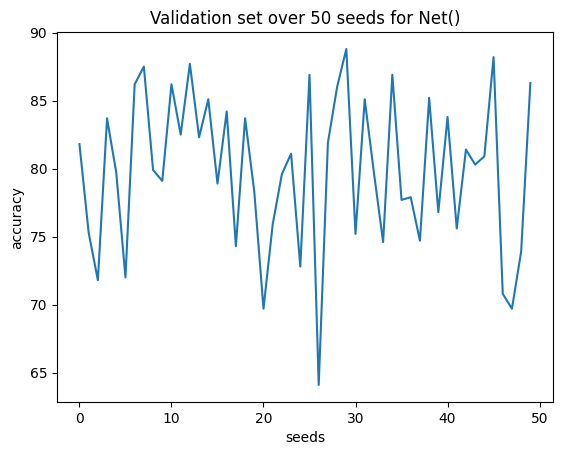

In [5]:
import matplotlib.pyplot as plt

plt.plot(accs_val)
plt.xlabel('seeds')
plt.ylabel('accuracy')
plt.title('Validation set over 50 seeds for Net()');
plt.savefig('C1val50seeds_net.png')

In [6]:
def resNet18():
    resNet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    resNet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet18

In [7]:
%%time
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      ])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='train', transform=data_transform, download=download)

accs_val = []

for seed in  range(0, 50):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(train_dataset, indx_train)
  val_data = Subset(val_dataset, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=32, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=128, 
                                             shuffle=False)

  model = resNet18()
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

  for epoch in range(50):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
  accs_val.append(test(model, device, val_loader))

accs_val = np.array(accs_val)

print('Val acc over 5 instances on dataset: %s %.2f +- %.2f (var: %.2f)'%(data_flag, accs_val.mean(), accs_val.std(), accs_val.var()))
     

Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 0 [0/10 (0%)]	Loss: 0.715053
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000419
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000131
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000077
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000062
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000049
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000042
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000038
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000034
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000031


c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 1.9504, Accuracy: 672/1000 (67.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.706821
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000519
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000121
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000070
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000050
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000039
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000032
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000028
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000024
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000022

Val set: Average loss: 0.6656, Accuracy: 821/1000 (82.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.715773
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000437
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000100
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000058
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000043
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000034
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000029
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000025
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000022
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000020

Val set: Average loss: 1.0525, Accuracy: 724/1000 (72.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.961484
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000721
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000247
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000118
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000095
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000078
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000063
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000053
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000047
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000042

Val set: Average loss: 0.8290, Accuracy: 758/1000 (75.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.874789
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000449
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000134
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000075
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000052
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000042
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000036
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000031
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000027
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000025

Val set: Average loss: 0.9823, Accuracy: 758/1000 (75.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.637897
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000565
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000119
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000064
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000042
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000031
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000025
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000021
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000019
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000017

Val set: Average loss: 0.9416, Accuracy: 752/1000 (75.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.714247
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000405
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000172
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000100
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000060
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000044
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000036
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000031
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000027
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000024

Val set: Average loss: 1.0686, Accuracy: 716/1000 (71.60%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.573494
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000330
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000102
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000069
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000058
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000049
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000042
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000038
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000034
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000031

Val set: Average loss: 0.6176, Accuracy: 806/1000 (80.60%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.526455
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000582
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000093
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000041
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000026
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000021
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000017
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000015
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000014
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000012

Val set: Average loss: 0.5106, Accuracy: 848/1000 (84.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.828252
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000713
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000187
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000094
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000066
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000052
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000043
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000037
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000032
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000029

Val set: Average loss: 1.6045, Accuracy: 650/1000 (65.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.743441
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000414
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000100
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000050
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000034
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000026
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000022
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000019
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000017
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000016

Val set: Average loss: 0.4772, Accuracy: 829/1000 (82.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.758544
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000557
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000184
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000114
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000083
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000059
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000046
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000039
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000035
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000031

Val set: Average loss: 0.4764, Accuracy: 847/1000 (84.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.602701
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000188
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000049
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000031
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000023
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000018
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000015
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000013
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000011
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000010

Val set: Average loss: 1.0216, Accuracy: 788/1000 (78.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 1.003746
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000488
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000122
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000063
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000039
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000029
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000024
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000021
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000020
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000019

Val set: Average loss: 1.6296, Accuracy: 698/1000 (69.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.801811
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000306
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000073
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000040
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000027
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000020
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000016
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000014
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000013
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000012

Val set: Average loss: 1.1623, Accuracy: 759/1000 (75.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.832863
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000839
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000198
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000096
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000066
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000051
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000042
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000036
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000032
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000029

Val set: Average loss: 0.9102, Accuracy: 717/1000 (71.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.875844
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000563
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000122
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000063
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000042
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000032
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000026
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000023
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000021
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000019

Val set: Average loss: 0.6399, Accuracy: 790/1000 (79.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.623579
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000427
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000096
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000046
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000030
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000023
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000019
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000017
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000016
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000015

Val set: Average loss: 1.7953, Accuracy: 660/1000 (66.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.769808
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000659
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000176
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000107
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000074
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000059
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000050
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000044
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000040
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000036

Val set: Average loss: 0.5277, Accuracy: 837/1000 (83.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.693653
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000388
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000094
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000054
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000041
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000033
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000028
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000025
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000023
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000021

Val set: Average loss: 0.6079, Accuracy: 827/1000 (82.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.649797
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000458
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000151
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000103
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000080
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000062
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000052
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000045
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000040
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000035

Val set: Average loss: 1.0907, Accuracy: 697/1000 (69.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.841997
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000765
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000283
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000194
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000138
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000117
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000098
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000083
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000072
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000063

Val set: Average loss: 0.7756, Accuracy: 787/1000 (78.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.791765
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000643
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000169
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000091
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000062
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000046
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000037
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000032
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000028
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000026

Val set: Average loss: 0.5072, Accuracy: 808/1000 (80.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.637569
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000534
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000173
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000069
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000041
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000031
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000027
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000024
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000022
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000021

Val set: Average loss: 2.1424, Accuracy: 585/1000 (58.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.665989
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000386
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000101
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000047
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000030
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000025
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000022
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000020
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000018
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000016

Val set: Average loss: 0.9831, Accuracy: 769/1000 (76.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.668114
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000310
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000099
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000050
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000036
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000030
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000027
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000024
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000021
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000019

Val set: Average loss: 1.5241, Accuracy: 708/1000 (70.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.856390
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000909
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000187
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000091
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000066
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000054
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000045
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000038
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000034
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000031

Val set: Average loss: 1.3010, Accuracy: 682/1000 (68.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.640761
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000362
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000092
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000054
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000038
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000031
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000026
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000024
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000022
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000020

Val set: Average loss: 0.9107, Accuracy: 766/1000 (76.60%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.674970
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000618
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000181
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000104
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000070
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000054
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000045
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000039
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000035
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000031

Val set: Average loss: 1.1055, Accuracy: 769/1000 (76.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.788778
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000360
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000117
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000075
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000053
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000039
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000032
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000028
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000025
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000022

Val set: Average loss: 1.0585, Accuracy: 769/1000 (76.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.873166
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000464
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000149
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000092
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000072
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000060
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000051
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000045
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000040
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000036

Val set: Average loss: 1.0125, Accuracy: 759/1000 (75.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.667167
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000334
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000101
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000052
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000034
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000026
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000022
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000020
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000018
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000017

Val set: Average loss: 0.7790, Accuracy: 828/1000 (82.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.732690
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000415
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000163
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000130
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000106
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000089
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000077
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000067
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000060
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000053

Val set: Average loss: 1.6499, Accuracy: 678/1000 (67.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.708258
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000704
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000220
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000125
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000090
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000076
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000065
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000056
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000049
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000044

Val set: Average loss: 1.0828, Accuracy: 669/1000 (66.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.880881
Train Epoch: 5 [0/10 (0%)]	Loss: 0.001031
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000312
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000193
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000147
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000114
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000096
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000084
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000073
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000064

Val set: Average loss: 0.3317, Accuracy: 879/1000 (87.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.823901
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000528
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000204
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000090
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000056
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000043
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000035
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000030
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000026
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000024

Val set: Average loss: 0.6236, Accuracy: 812/1000 (81.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.589013
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000782
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000182
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000090
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000051
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000035
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000028
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000024
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000021
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000019

Val set: Average loss: 0.7500, Accuracy: 715/1000 (71.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.755104
Train Epoch: 5 [0/10 (0%)]	Loss: 0.001002
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000298
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000163
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000100
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000070
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000055
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000048
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000042
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000039

Val set: Average loss: 0.5378, Accuracy: 792/1000 (79.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.693898
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000980
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000283
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000166
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000125
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000101
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000083
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000070
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000061
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000054

Val set: Average loss: 0.5735, Accuracy: 808/1000 (80.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.610384
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000364
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000090
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000044
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000030
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000023
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000020
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000018
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000016
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000015

Val set: Average loss: 0.5858, Accuracy: 810/1000 (81.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.823395
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000381
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000115
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000072
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000058
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000050
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000043
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000039
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000035
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000032

Val set: Average loss: 1.4386, Accuracy: 708/1000 (70.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.616950
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000238
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000064
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000042
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000032
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000025
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000020
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000018
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000016
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000015

Val set: Average loss: 1.4217, Accuracy: 725/1000 (72.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.695829
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000703
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000186
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000107
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000078
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000061
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000050
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000043
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000037
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000034

Val set: Average loss: 0.6619, Accuracy: 789/1000 (78.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.721861
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000549
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000152
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000084
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000056
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000041
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000033
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000028
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000025
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000023

Val set: Average loss: 0.9651, Accuracy: 776/1000 (77.60%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.939676
Train Epoch: 5 [0/10 (0%)]	Loss: 0.001292
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000386
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000203
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000136
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000113
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000097
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000084
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000074
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000066

Val set: Average loss: 0.6046, Accuracy: 802/1000 (80.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.829804
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000246
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000069
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000041
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000032
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000024
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000019
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000017
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000015
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000014

Val set: Average loss: 1.9066, Accuracy: 620/1000 (62.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 1.004487
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000528
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000136
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000081
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000061
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000050
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000043
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000039
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000035
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000033

Val set: Average loss: 1.4370, Accuracy: 655/1000 (65.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.616067
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000250
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000066
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000036
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000025
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000019
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000015
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000012
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000011
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000010

Val set: Average loss: 2.0749, Accuracy: 642/1000 (64.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.999577
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000602
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000182
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000127
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000084
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000060
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000048
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000041
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000036
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000033

Val set: Average loss: 0.9688, Accuracy: 717/1000 (71.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.856159
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000863
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000181
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000096
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000068
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000052
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000043
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000037
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000033
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000030

Val set: Average loss: 1.1005, Accuracy: 751/1000 (75.10%)

Val acc over 5 instances on dataset: pneumoniamnist 75.06 +- 6.58 (var: 43.36)
CPU times: total: 31min 6s
Wall time: 15min 8s


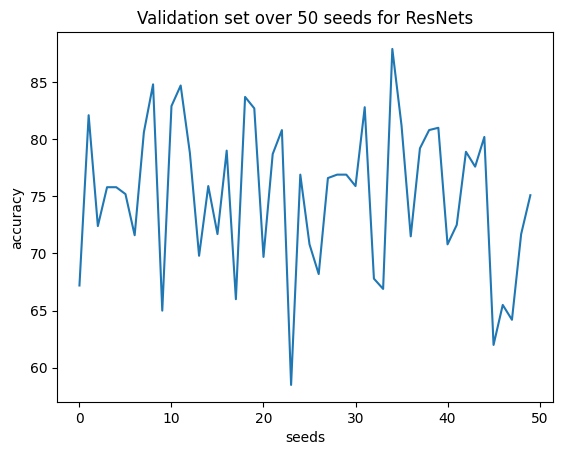

In [8]:
import matplotlib.pyplot as plt

plt.plot(accs_val)
plt.xlabel('seeds')
plt.ylabel('accuracy')
plt.title('Validation set over 50 seeds for ResNets');
plt.savefig('C1val50seeds_resnet.png')